In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from datetime import datetime
from functools import partial
import os

import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')  # 忽略一些warnings

# This allows multiple outputs from a single jupyter notebook cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.core.display import display, HTML
display(HTML("<style>.container{width:100% !important; }</style>"))

from IPython.display import display
pd.set_option('expand_frame_repr', True) # pycharm设置为False可以产生滑条，但vscode不能产生滑条所以会堆叠。因此vscode应该设置为True
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
pd.set_option('display.width', 180) # 每一行的宽度（避免换行）
# pd.set_option('display.max_rows', 100) # 显示的最大行数（避免只显示部分行数据）
# pd.set_option('display.max_columns', 1000) # 显示的最大列数（避免列显示不全）
# pd.set_option('display.float_format', lambda x: '%.3f' % x)    # 取消Pandas 科学计数法显示 + 可调节位数
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签`
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (10, 6) # 设置全局图片形状大小
%config InlineBackend.figure_format = 'svg' # or 'retina'
%matplotlib inline

from tqdm import tqdm

In [102]:
import os
import pandas as pd

# 定义根目录路径
root_directory = './data/stock_if_min_cffex/'  # 修改为你的实际路径

# 遍历目录及其子目录中的所有文件
for dirpath, dirnames, filenames in os.walk(root_directory):
    for filename in filenames:
        if filename.endswith('.csv'):
            file_path = os.path.join(dirpath, filename)
            
            # 读取CSV文件
            try:
                df = pd.read_csv(file_path, encoding='gbk', skiprows=1)
                df.rename(columns={'交易日期':'datetime', '期货价格':'price', '成交量':'volume'}, inplace=True)
                df.to_csv(file_path, index=False, encoding='utf-8')
            except Exception as e:
                print(f'读取文件{file_path}失败：{e}')
        
df


,datetime,price,volume
0,2024-07-29 09:30:00,4414.2,165
1,2024-07-29 09:31:00,4415.0,181
2,2024-07-29 09:32:00,4412.8,56
3,2024-07-29 09:33:00,4400.2,75
4,2024-07-29 09:34:00,4393.4,67
...,...,...,...
11853,2024-10-14 14:56:00,5485.4,128
11854,2024-10-14 14:57:00,5490.6,113
11855,2024-10-14 14:58:00,5495.4,167
11856,2024-10-14 14:59:00,5486.0,151


In [104]:
DATA_PATH = './data/stock_if_min_cffex/'
futures = 'IC'
icname = 'IC2206'

# ===遍历读取所有合约持仓数据
files = os.listdir(DATA_PATH + futures + '/')
files = sorted(files)
df_list = []
# 遍历
for i in tqdm(range(0, len(files)-1)):
    # 超过当月合约则终止循环
    # if icname in files[i]:
        # break
        
    # 近期
    df1 = pd.read_csv(DATA_PATH + futures + '/' + files[i], parse_dates=['datetime'])
    df1['front_month'] = files[i].split('.')[0]
    df1.sort_values(by=['datetime'], inplace=True)

    # 远期
    df2 = pd.read_csv(DATA_PATH + futures + '/' + files[i+1], parse_dates=['datetime'])
    df2['back_month'] = files[i+1].split('.')[0]
    df2.sort_values(by=['datetime'], inplace=True)

    # 合并相邻合约，并删除不必要的字段
    df_merge = pd.merge(left=df1, right=df2, on=['datetime'], how='left', sort=True)

    # 分钟级别数据
    df_merge.drop(['volume_x', 'volume_y'], axis=1, inplace=True)  #分钟级别数据
    df_merge['delivery'] = False
    df_merge.loc[df_merge['datetime'].dt.date == df_merge['datetime'].dt.date.max(), 'delivery'] = True
    df_merge.dropna(inplace=True)
    df_list.append(df_merge)



100%|██████████| 43/43 [00:02<00:00, 17.41it/s]


In [105]:
df_complete = pd.concat(df_list, ignore_index=True)
# drop duplicate timestamps (we trade one pair of contracts at a time)
df_complete.drop_duplicates(subset='datetime', inplace=True)

# delete boundary timestamp 9:30, 11:30, 13:00, 15:00
df_complete = df_complete[~df_complete['datetime'].dt.strftime('%H:%M').isin(['09:30', '11:30', '13:00', '15:00'])]

df_complete['diff'] = df_complete['price_x'] - df_complete['price_y']  # 计算点数差

df_complete.sort_values('datetime', inplace=True)
df_complete.reset_index(drop=True, inplace=True)


In [107]:
df_complete.set_index('datetime', inplace=True)

In [108]:
df_complete

,price_x,front_month,price_y,back_month,delivery,diff
datetime,,,,,,
2021-05-28 09:31:00,6662.4,IC2106,6616.2,IC2107,False,46.2
2021-05-28 09:32:00,6656.0,IC2106,6609.4,IC2107,False,46.6
2021-05-28 09:33:00,6664.2,IC2106,6616.0,IC2107,False,48.2
2021-05-28 09:34:00,6663.0,IC2106,6619.2,IC2107,False,43.8
2021-05-28 09:35:00,6663.0,IC2106,6617.0,IC2107,False,46.0
...,...,...,...,...,...,...
2024-10-14 14:55:00,5604.2,IC2410,5595.2,IC2411,True,9.0
2024-10-14 14:56:00,5603.6,IC2410,5594.8,IC2411,True,8.8
2024-10-14 14:57:00,5603.2,IC2410,5593.0,IC2411,True,10.2


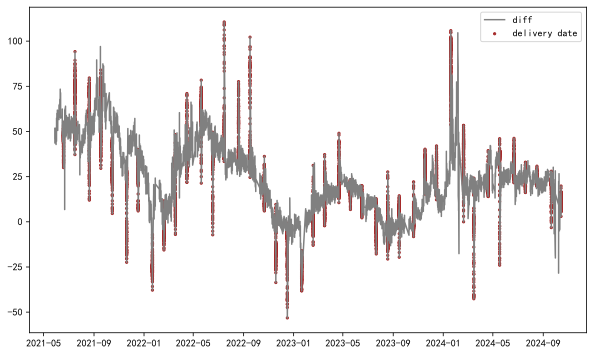

In [109]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(df_complete['diff'], color='gray', label='diff')
plt.scatter(df_complete[df_complete['delivery'] == True].index, df_complete[df_complete['delivery'] == True]['diff'], color='brown', label='delivery date', s=5)
plt.legend()

<AxesSubplot:xlabel='datetime'>

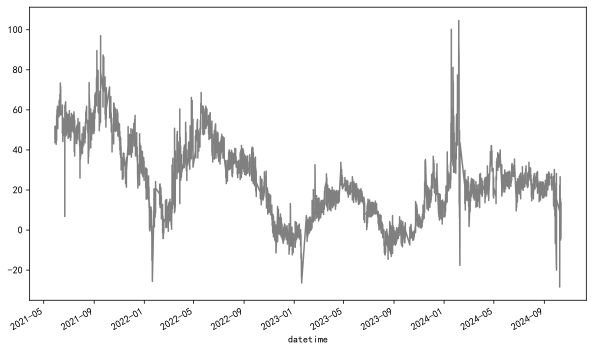

In [110]:
df_complete[~df_complete['delivery']]['diff'].plot(figsize=(10, 6), color='gray', label='diff')

In [111]:
df_complete[~df_complete['delivery']]['diff'].describe()
df_complete[df_complete['delivery']]['diff'].describe()

count    184688.000000
mean         25.010440
std          18.973933
min         -28.400000
25%          11.400000
50%          22.600000
75%          37.800000
max         104.600000
Name: diff, dtype: float64

count    9758.000000
mean       22.733224
std        25.855258
min       -53.200000
25%         6.450000
50%        22.400000
75%        36.600000
max       110.600000
Name: diff, dtype: float64

In [115]:
df_complete.groupby(df_complete['datetime'].dt.date)['diff'].size()

datetime
2021-05-28    238
2021-05-31    238
2021-06-01    238
2021-06-02    238
2021-06-03    238
             ... 
2024-10-08    238
2024-10-09    238
2024-10-10    238
2024-10-11    238
2024-10-14    238
Name: diff, Length: 817, dtype: int64

In [118]:
def signal_futures_arbitrage(df, para=[60, 45, 40]):
    max_limit = int(para[0])  # 开空点差，做空
    sell_close = int(para[1])  # 平仓点差，平仓
    min_limit = int(para[2])  # 开多点差，做多

    # 找出做空信号
    condition1 = df['diff'] > max_limit  # 当前K线的收盘价 > 上轨
    condition2 = df['diff'].shift(1) <= max_limit  # 之前K线的收盘价 <= 上轨
    df.loc[condition1 & condition2, 'signal_short'] = -1  # 将产生做空信号的那根K线的signal设置为1，1代表做多

    # 找出做空平仓信号
    condition1 = df['diff'] < sell_close  # 当前K线的收盘价 < 中轨
    condition2 = df['diff'].shift(1) >= sell_close  # 之前K线的收盘价 >= 中轨
    condition3 = df['front_month'] != df['front_month'].shift(-1) # 合约到期当天强制平仓
    df.loc[(condition1 & condition2) | condition3, 'signal_short'] = 0  # 将产生平仓信号当天的signal设置为0，0代表平仓

    # 找出做多信号
    condition1 = df['diff'] < min_limit  # 当前K线的收盘价 < 下轨
    condition2 = df['diff'].shift(1) >= min_limit  # 之前K线的收盘价 >= 下轨
    df.loc[condition1 & condition2, 'signal_long'] = 1  # 将产生做多信号的那根K线的signal设置为-1，-1代表做空

    # 找出做多平仓信号
    condition1 = df['diff'] > sell_close  # 当前K线的收盘价 > 中轨
    condition2 = df['diff'].shift(1) <= sell_close  # 之前K线的收盘价 <= 中轨
    condition3 = df['front_month'] != df['front_month'].shift(-1) # 合约到期当天强制平仓
    df.loc[(condition1 & condition2) | condition3, 'signal_long'] = 0  # 将产生平仓信号当天的signal设置为0，0代表平仓

    # 合并做多做空信号，去除重复信号
    df['signal'] = df[['signal_long', 'signal_short']].sum(axis=1, min_count=1,
                                                           skipna=True)  # 若你的pandas版本是最新的，请使用本行代码代替上面一行
    temp = df[df['signal'].notnull()][['signal']]
    temp = temp[temp['signal'] != temp['signal'].shift(1)]
    df['signal'] = temp['signal']

    return df

para = [60, 35, 20]
df = signal_futures_arbitrage(df_complete, para=para)
df

,datetime,price_x,front_month,price_y,back_month,delivery,diff,signal_short,signal_long,signal
0,2021-05-28 09:31:00,6662.4,IC2106,6616.2,IC2107,False,46.2,NaN,NaN,NaN
1,2021-05-28 09:32:00,6656.0,IC2106,6609.4,IC2107,False,46.6,NaN,NaN,NaN
2,2021-05-28 09:33:00,6664.2,IC2106,6616.0,IC2107,False,48.2,NaN,NaN,NaN
3,2021-05-28 09:34:00,6663.0,IC2106,6619.2,IC2107,False,43.8,NaN,NaN,NaN
4,2021-05-28 09:35:00,6663.0,IC2106,6617.0,IC2107,False,46.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
194441,2024-10-14 14:55:00,5604.2,IC2410,5595.2,IC2411,True,9.0,NaN,NaN,NaN
194442,2024-10-14 14:56:00,5603.6,IC2410,5594.8,IC2411,True,8.8,NaN,NaN,NaN
194443,2024-10-14 14:57:00,5603.2,IC2410,5593.0,IC2411,True,10.2,NaN,NaN,NaN
194444,2024-10-14 14:58:00,5604.0,IC2410,5595.2,IC2411,True,8.8,NaN,NaN,NaN


In [120]:
def calc_positions(df):
    df['signal_'] = df['signal']
    df['signal_'].fillna(method='ffill', inplace=True)
    df['signal_'].fillna(value=0, inplace=True) 
    df['pos'] = df['signal_'].shift()
    df['pos'].fillna(value=0, inplace=True)  

    # close position on delivery day
    condition1 = df['front_month'] != df['front_month'].shift(-1)
    df.loc[condition1, 'pos'] = 0

    df.loc[df['pos'] == 1, 'long_contract'] = df['front_month']
    df.loc[df['pos'] == 1, 'short_contract'] = df['back_month']

    df.loc[df['pos'] == -1, 'long_contract'] = df['back_month']
    df.loc[df['pos'] == -1, 'short_contract'] = df['front_month']
    return df

df = calc_positions(df)
df

,datetime,price_x,front_month,price_y,back_month,delivery,diff,signal_short,signal_long,signal,signal_,pos,long_contract,short_contract
0,2021-05-28 09:31:00,6662.4,IC2106,6616.2,IC2107,False,46.2,NaN,NaN,NaN,0.0,0.0,NaN,NaN
1,2021-05-28 09:32:00,6656.0,IC2106,6609.4,IC2107,False,46.6,NaN,NaN,NaN,0.0,0.0,NaN,NaN
2,2021-05-28 09:33:00,6664.2,IC2106,6616.0,IC2107,False,48.2,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,2021-05-28 09:34:00,6663.0,IC2106,6619.2,IC2107,False,43.8,NaN,NaN,NaN,0.0,0.0,NaN,NaN
4,2021-05-28 09:35:00,6663.0,IC2106,6617.0,IC2107,False,46.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194441,2024-10-14 14:55:00,5604.2,IC2410,5595.2,IC2411,True,9.0,NaN,NaN,NaN,1.0,1.0,IC2410,IC2411
194442,2024-10-14 14:56:00,5603.6,IC2410,5594.8,IC2411,True,8.8,NaN,NaN,NaN,1.0,1.0,IC2410,IC2411
194443,2024-10-14 14:57:00,5603.2,IC2410,5593.0,IC2411,True,10.2,NaN,NaN,NaN,1.0,1.0,IC2410,IC2411
194444,2024-10-14 14:58:00,5604.0,IC2410,5595.2,IC2411,True,8.8,NaN,NaN,NaN,1.0,1.0,IC2410,IC2411


In [122]:
# =====计算收益
def equity_points_earn_calc(df, slippage=2):
    # 全部使用点差收盘价计算，约等于
    # =====找出开仓、平仓的k线
    condition1 = df['pos'] != 0  # 当前周期不为空仓
    condition2 = df['pos'] != df['pos'].shift(1)  # 当前周期和上个周期持仓方向不一样。
    open_pos_condition = condition1 & condition2

    condition1 = df['pos'] != 0  # 当前周期不为空仓
    condition2 = df['pos'] != df['pos'].shift(-1)  # 当前周期和下个周期持仓方向不一样。
    close_pos_condition = condition1 & condition2

    # =====对每次交易进行分组
    df.loc[open_pos_condition, 'start_time'] = df['datetime']
    df['start_time'].fillna(method='ffill', inplace=True)
    df.loc[df['pos'] == 0, 'start_time'] = pd.NaT

    # ===在开仓时
    # 开仓价格：理论收盘价加上相应滑点
    df.loc[open_pos_condition, 'open_pos_price'] = df['diff'] + (slippage * df['pos'])
    # 开仓之后剩余的钱，扣除手续费

    # ===开仓之后每根K线结束时
    # 买入之后open_pos_price不再发生变动
    for _ in ['open_pos_price']:
        df[_].fillna(method='ffill', inplace=True)
    df.loc[df['pos'] == 0, ['open_pos_price']] = None
    # ===在平仓时
    # 计算平仓时的点数差值，并计算平仓时赚取的点差
    df.loc[close_pos_condition, 'close_pos_price'] = df['diff'] + (slippage * df['pos'])
    condition3 = pd.notna(df['open_pos_price']) & pd.notna(df['close_pos_price'])
    df.loc[condition3, 'points_earn'] = (df['close_pos_price'] - df['open_pos_price']) * df['pos']

    # ===计算赚取的总点数
    df['points_sum'] = df['points_earn'].expanding(min_periods=1).sum()
    return df


slippage = 2  # 滑点 ，这里使用固定值，n个点差

# 收益情况评价
df = equity_points_earn_calc(df, slippage=slippage)

df

,datetime,price_x,front_month,price_y,back_month,delivery,diff,signal_short,signal_long,signal,signal_,pos,long_contract,short_contract,start_time,open_pos_price,close_pos_price,points_earn,points_sum
0,2021-05-28 09:31:00,6662.4,IC2106,6616.2,IC2107,False,46.2,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN
1,2021-05-28 09:32:00,6656.0,IC2106,6609.4,IC2107,False,46.6,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN
2,2021-05-28 09:33:00,6664.2,IC2106,6616.0,IC2107,False,48.2,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN
3,2021-05-28 09:34:00,6663.0,IC2106,6619.2,IC2107,False,43.8,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN
4,2021-05-28 09:35:00,6663.0,IC2106,6617.0,IC2107,False,46.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194441,2024-10-14 14:55:00,5604.2,IC2410,5595.2,IC2411,True,9.0,NaN,NaN,NaN,1.0,1.0,IC2410,IC2411,2024-09-23 09:47:00,25.2,NaN,NaN,335.6
194442,2024-10-14 14:56:00,5603.6,IC2410,5594.8,IC2411,True,8.8,NaN,NaN,NaN,1.0,1.0,IC2410,IC2411,2024-09-23 09:47:00,25.2,NaN,NaN,335.6
194443,2024-10-14 14:57:00,5603.2,IC2410,5593.0,IC2411,True,10.2,NaN,NaN,NaN,1.0,1.0,IC2410,IC2411,2024-09-23 09:47:00,25.2,NaN,NaN,335.6
194444,2024-10-14 14:58:00,5604.0,IC2410,5595.2,IC2411,True,8.8,NaN,NaN,NaN,1.0,1.0,IC2410,IC2411,2024-09-23 09:47:00,25.2,10.8,-14.4,321.2


In [142]:
x = df.set_index('datetime')[['points_earn']]
x = x[x!=0]
x

,points_earn
datetime,
2021-06-18 14:15:00,25.4
2021-06-21 09:36:00,NaN
2021-07-16 14:58:00,-12.8
2021-08-17 14:49:00,18.6
2021-08-20 14:14:00,34.8
...,...
2024-06-20 09:32:00,17.0
2024-07-19 14:58:00,4.4
2024-08-16 14:58:00,11.4


In [149]:
df_daily = df.set_index('datetime')[['points_earn']].resample('D').sum()
df_daily

,points_earn
datetime,
2021-06-18,25.4
2021-06-19,0.0
2021-06-20,0.0
2021-06-21,0.0
2021-06-22,0.0
...,...
2024-10-10,0.0
2024-10-11,0.0
2024-10-12,0.0


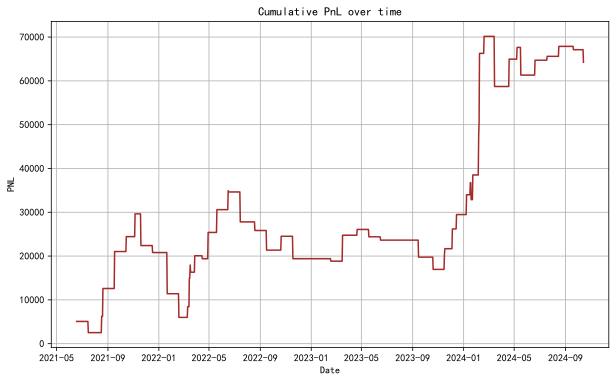

,Sharpe,Sortino,Max Drawdown,Win Ratio
0,0.777087,0.275251,-0.336944,0.026337


In [150]:
def get_performance(pnl_series: pd.Series):
    """
    pnl_series: pandas Series with date as index and pnl as values
    """
    # Convert pnl_series to a DataFrame
    aa = pnl_series.to_frame(name="final.pnl")
    aa.index = pd.to_datetime(aa.index)

    # Calculate cumulative PnL
    pnl = aa["final.pnl"].cumsum()
    date_format = aa.index

    # Plot the performance
    fig, ax = plt.subplots(sharex=True, figsize=(10, 6))
    sns.lineplot(x=date_format, y=pnl, ax=ax, dashes=True, color='brown')
    ax.set_title("Cumulative PnL over time")
    ax.set_xlabel("Date")
    ax.set_ylabel("PNL")
    plt.grid(True)
    plt.show()

    # Calculate performance metrics
    n_days = len(aa)
    daily_return = aa["final.pnl"]

    if daily_return.std() == 0:
        sharpe = 0
        sortino = 0
    else:
        sharpe = daily_return.mean() / daily_return.std() * np.sqrt(250)
        downside_std = daily_return[daily_return < 0].std()
        sortino = daily_return.mean() / downside_std * np.sqrt(250) if downside_std != 0 else 0

    drawdown = ((pnl.cummax() - pnl).max() / pnl.cummax().max()) if pnl.cummax().max() != 0 else 0
    win_ratio = sum(daily_return > 0) / n_days

    # Create a DataFrame with all performance metrics
    performance_df = pd.DataFrame({
        "Sharpe": [sharpe],
        "Sortino": [sortino],
        "Max Drawdown": [-drawdown],
        "Win Ratio": [win_ratio]
    })

    return performance_df


get_performance(df_daily['points_earn']*200)

In [139]:
df = df[pd.notna(df['points_earn'])]
make_times = len(df[df['points_earn'] > 0])  # 赚钱次数
loss_times = len(df[df['points_earn'] < 0])  # 亏损次数
print('参数：', para, '策略最终收益：', df.iloc[-1]['points_sum'], '盈利次数：', make_times, '亏损次数：', loss_times)
df_order_list = df[
    ['start_time', 'datetime', 'open_pos_price', 'close_pos_price', 'points_earn', 'pos', 'long_contract', 'short_contract']]
df_order_list.rename(columns={'start_time': 'start_time', 'datetime': '平仓时间', 'open_pos_price': '开仓点差',
                              'close_pos_price': '平仓点差',
                              'points_earn': '赚取点差', 'pos': '持仓方向', 'long_contract': 'long_contract', 'short_contract': 'short_contract'}, inplace=True)
print(df_order_list)

参数： [60, 35, 20] 策略最终收益： 321.1999999999989 盈利次数： 41 亏损次数： 25
                start_time            平仓时间  开仓点差  平仓点差  赚取点差  持仓方向 long_contract short_contract
3525   2021-06-03 11:23:00 2021-06-18 14:15:00      57.0      31.6      25.4      -1.0        IC2107         IC2106
3575   2021-06-21 09:36:00 2021-06-21 09:36:00      52.2      52.2       0.0       1.0        IC2107         IC2108
8328   2021-06-21 10:41:00 2021-07-16 14:58:00      52.4      65.2     -12.8      -1.0        IC2108         IC2107
13555  2021-08-13 10:10:00 2021-08-17 14:49:00      56.6      38.0      18.6      -1.0        IC2109         IC2108
14234  2021-08-19 11:15:00 2021-08-20 14:14:00      58.0      23.2      34.8      -1.0        IC2109         IC2108
...                    ...                 ...       ...       ...       ...       ...           ...            ...
176359 2024-05-20 09:41:00 2024-06-20 09:32:00      20.4      37.4      17.0       1.0        IC2406         IC2407
181592 2024-06-24 09:32:00 2024

In [154]:
df['diff'].describe()
df[~df['delivery']]['diff'].describe()

count    69.000000
mean     28.002899
std      24.180631
min     -40.600000
25%      15.800000
50%      33.400000
75%      36.000000
max      97.400000
Name: diff, dtype: float64

count    25.000000
mean     35.464000
std       5.274378
min      22.200000
25%      34.200000
50%      35.400000
75%      36.800000
max      50.200000
Name: diff, dtype: float64